In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential

## Import the Dataset

Import the dataset and look at some examples.

The MNIST dataset consists of handwritten digits (0-9).
Pixel values are from 0 to 255.

In [2]:
# load in the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
# note that these are just numpy arrays
type(x_train)

numpy.ndarray

In [4]:
# the x training data is 60,000 examples of 28x28 images
print(x_train.shape)

(60000, 28, 28)


In [5]:
print(y_train.shape)

(60000,)


Look at some numbers



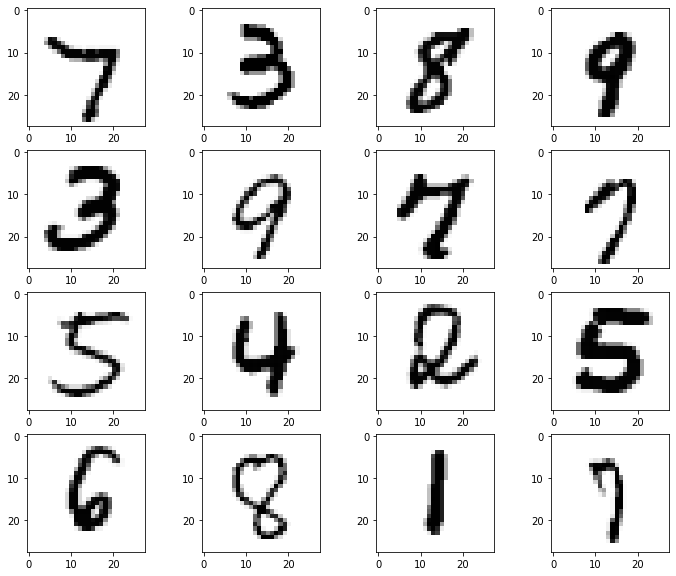

In [6]:
# Look at some random numbers
X_shuffle = shuffle(x_train.copy(), random_state=42)

print('Look at some numbers\n')
plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle[i].reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

In [7]:
X_shuffle.max()

255

## Data Preprocessing

We need to do the following to preprocess the data:

1. Divide the values by the max value (255)
2. Add a color channel (require by the convolutional layer)

By default Keras assumes images are formatted as (number of examples, x-dim, y-dim, number of colors)

An RGB image has 3 color channels, greyscale as 1 color channel

In [8]:
# divide by the color channel
x_train = x_train / 255.
x_test = x_test / 255.

In [9]:
# add the color channel
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

## Setup the Model

This is a very basic convolutional network.
There are essentially two sections
1. convolutional feature extraction layers
2. dense (fully-connected) classifier layers

In [10]:
num_classes=10
filters=32
pool_size=2
kernel_size=3
dropout=0.2
input_shape = (28,28,1)

model = Sequential([
      # convolutional feature extraction
      # ConvNet 1
      keras.layers.Conv2D(filters, kernel_size, padding = 'valid',
              activation='relu',
              input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=pool_size),

      # ConvNet 2
      keras.layers.Conv2D(filters, kernel_size,
              padding = 'valid',
              activation='relu'),
      keras.layers.MaxPooling2D(pool_size=pool_size),

      # classification 
      # will retrain from here
      keras.layers.Flatten(name='flatten'),

      keras.layers.Dropout(dropout),
      keras.layers.Dense(128, activation='relu'),
      
      keras.layers.Dropout(dropout, name='penult'),
      keras.layers.Dense(num_classes, activation='softmax', name='last')
  ])

In [11]:
# print summary of model as check
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [12]:
# print image of model as check
keras.utils.plot_model(model, show_shapes=True, dpi=48)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [13]:
es = keras.callbacks.EarlyStopping(min_delta=0.001, patience=2)

In [14]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

history = model.fit(x_train,y_train,
                    validation_split=0.2,
                    batch_size=32,
                    epochs=1000,
                    callbacks=[es])

Epoch 1/1000
1500/1500 [==============================] - 39s 25ms/step - loss: 0.4359 - accuracy: 0.8614 - val_loss: 0.0571 - val_accuracy: 0.9837
Epoch 2/1000
1500/1500 [==============================] - 35s 23ms/step - loss: 0.0756 - accuracy: 0.9756 - val_loss: 0.0426 - val_accuracy: 0.9875
Epoch 3/1000
1500/1500 [==============================] - 35s 24ms/step - loss: 0.0550 - accuracy: 0.9824 - val_loss: 0.0382 - val_accuracy: 0.9890
Epoch 4/1000
1500/1500 [==============================] - 35s 23ms/step - loss: 0.0434 - accuracy: 0.9865 - val_loss: 0.0341 - val_accuracy: 0.9902
Epoch 5/1000
1500/1500 [==============================] - 35s 24ms/step - loss: 0.0362 - accuracy: 0.9888 - val_loss: 0.0325 - val_accuracy: 0.9911
Epoch 6/1000
1500/1500 [==============================] - 35s 24ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.0370 - val_accuracy: 0.9909
Epoch 7/1000
1500/1500 [==============================] - 36s 24ms/step - loss: 0.0260 - accuracy: 0.9911 - val_

In [16]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_accuracy'] + history.history['accuracy']),
                        max(history.history['val_accuracy'] + history.history['accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

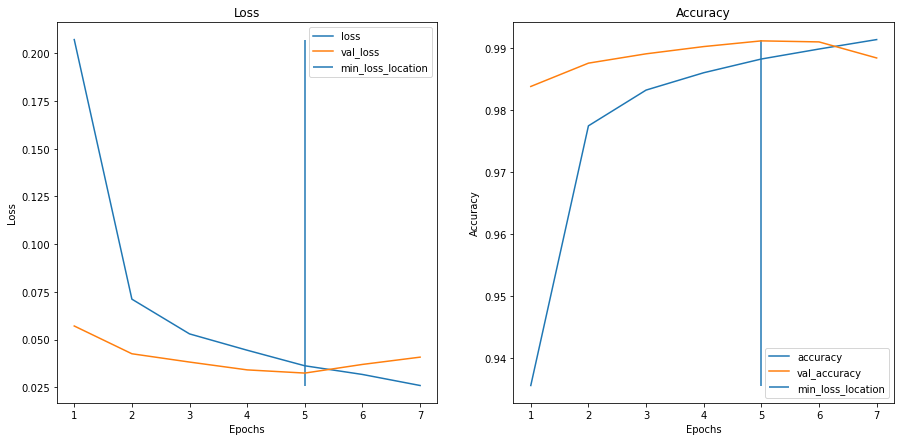

In [17]:
plot_training_curves(history)

In [18]:
# predict using the model
preds = model.predict(x_test)

In [19]:
x_test.shape

(10000, 28, 28, 1)

In [20]:
preds.shape

(10000, 10)

In [21]:
preds[0]

array([3.35114464e-10, 5.50528014e-08, 9.16632757e-07, 3.37572033e-07,
       2.11923916e-11, 1.06260285e-10, 7.44207810e-13, 9.99998450e-01,
       3.88885102e-09, 2.19733948e-07], dtype=float32)

In [22]:
# classify the test set

# predict using the model
preds = model.predict(x_test)
# argmax along rows to get classification
preds = np.argmax(preds, axis=1).astype("uint8")

accuracy_score(y_test, preds)

0.9901

## Working with 'Real' Images

In [23]:
!pip install pillow
from PIL import Image

import matplotlib.pyplot as plt
import glob

pillow (PIL) is the python package for working with real images:

[https://pillow.readthedocs.io/en/stable/index.html](https://pillow.readthedocs.io/en/stable/index.html)

I have some images of cats in google drive that I'll be using for example.
How to mount google drive in the colab env:
[https://www.kaggle.com/questions-and-answers/162449](https://www.kaggle.com/questions-and-answers/162449)

In [24]:
cat_images = glob.glob('drive/MyDrive/training_set/cats/*')
cat_images[:10]

[]

Open the image and resize it.
Note that the hand written images should be resized to (28,28).

[https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize)

In [25]:
size = (28,28)
im = Image.open(cat_images[0])
plt.imshow(im)

IndexError: list index out of range

In [ ]:
im = im.resize(size)
plt.imshow(im)

Convert the image to greyscale with "L" option.

[https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert)

In [ ]:
im = im.convert("L")
plt.imshow(im)

Build an array for training in the neural network

In [ ]:
im = np.array(im)
im

In [ ]:
print(im.shape)

In [ ]:
# load each image, run the initial conversion steps, combine in a list
new_images = []
new_size = (28,28)
for im in cat_images[:10]:
  im = Image.open(im).convert("L").resize(new_size)
  new_images.append(np.array(im))
  

In [ ]:
# "stack" the arrays
x_train = np.stack(new_images)
print(x_train.shape)

In [ ]:
# as done in mnist add the color channel
x_train = x_train.reshape((10,28,28,1))
x_train.shape

## For Next Week



1. Start working on your dataset
2. Write the code to bring in your dataset (resize images to same as mnist)
3. Write the code to preprocess your dataset (same as mnist)